In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays


In [17]:
# Set seaborn style
sns.set(style="whitegrid")
colors = sns.color_palette("muted")
class_labels = {0: 'Electricity', 1: 'Chilled Water', 2: 'Steam', 3: 'Hot Water'}

In [18]:
#Load
train_df=pd.read_csv(r'C:\Users\imate\Documents\24.9.Notebooks_training\Final-pipeline\data\processed\merged_data.csv')

# Remove outliers

In [19]:
#Check which building has the max meter reading -> outlier remove!
print(train_df[train_df.meter_reading == train_df.meter_reading.max()])

        Unnamed: 0.1  Unnamed: 0  site_id  building_id primary_use  \
236943        236943      236943       15         1381      Office   
236944        236944      236944       15         1381      Office   
236945        236945      236945       15         1381      Office   
236946        236946      236946       15         1381      Office   
236947        236947      236947       15         1381      Office   
...              ...         ...      ...          ...         ...   
245392        245392      245392       15         1381      Office   
245393        245393      245393       15         1381      Office   
245394        245394      245394       15         1381      Office   
245395        245395      245395       15         1381      Office   
245396        245396      245396       15         1381      Office   

        square_feet  year_built  floor_count  meter          timestamp_x  ...  \
236943        84615      1963.0          NaN      2  2016-11-26 07:00:00  ... 

In [20]:
#check
train_df = train_df.drop(train_df[train_df['building_id'] == 1381].index)
print(train_df[train_df.meter_reading == train_df.meter_reading.max()])

       Unnamed: 0.1  Unnamed: 0  site_id  building_id primary_use  \
17546         17546       17546        2          221   Education   
17547         17547       17547        2          221   Education   
17548         17548       17548        2          221   Education   
17549         17549       17549        2          221   Education   
17550         17550       17550        2          221   Education   
...             ...         ...      ...          ...         ...   
26324         26324       26324        2          221   Education   
26325         26325       26325        2          221   Education   
26326         26326       26326        2          221   Education   
26327         26327       26327        2          221   Education   
26328         26328       26328        2          221   Education   

       square_feet  year_built  floor_count  meter          timestamp_x  ...  \
17546       204349      1993.0          NaN      1  2016-03-22 20:00:00  ...   
17547      

# Missing Value Imputation

In [21]:
def percent_missing_val(df):

  percent_missing = (df.isnull().sum() * 100) / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
  return missing_value_df


df = percent_missing_val(train_df)
df

,column_name,percent_missing
Unnamed: 0.1,Unnamed: 0.1,0.000000
Unnamed: 0,Unnamed: 0,0.000000
site_id,site_id,0.000000
building_id,building_id,0.000000
primary_use,primary_use,0.000000
square_feet,square_feet,0.000000
year_built,year_built,65.701140
floor_count,floor_count,61.993453
meter,meter,0.000000
timestamp_x,timestamp_x,0.000000


We have more than 50% of values missing from year_built and floor_count features, hence we will drop these two columns. We will now impute all the missing values in the other columns which are from our weather data. As we all know, that weather strongly varies from one location to another, also from month to month and from day to night. Using this information, we will impute the missing values. We will find the average site wise temperatures for each day of the month and use this to impute missing values.



In [22]:
train_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'site_id', 'building_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'meter', 'timestamp_x',
       'meter_reading', 'timestamp_y', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'hour', 'dayofweek', 'month',
       'dayofyear', 'day', 'year'],
      dtype='object')

In [23]:
def nan_fillers(df):
  air_temp_df=df.groupby(['site_id', 'day', 'month'])['air_temperature'].transform('mean')
  df['air_temperature'].fillna(air_temp_df, inplace=True)

  dew_temp_df=df.groupby(['site_id', 'day', 'month'])['dew_temperature'].transform('mean')
  df['dew_temperature'].fillna(dew_temp_df, inplace=True)

  cloud_df=df.groupby(['site_id', 'day', 'month'])['cloud_coverage'].transform('mean')
  df['cloud_coverage'].fillna(cloud_df, inplace=True)

  sea_level_df=df.groupby(['site_id', 'day', 'month'])['sea_level_pressure'].transform('mean')
  df['sea_level_pressure'].fillna(sea_level_df, inplace=True)

  precip_df=df.groupby(['site_id', 'day', 'month'])['precip_depth_1_hr'].transform('mean')
  df['precip_depth_1_hr'].fillna(precip_df, inplace=True)

  wind_dir_df=df.groupby(['site_id', 'day', 'month'])['wind_direction'].transform('mean')
  df['wind_direction'].fillna(wind_dir_df, inplace=True)

  wind_speed_df=df.groupby(['site_id', 'day', 'month'])['wind_speed'].transform('mean')
  df['wind_speed'].fillna(wind_speed_df, inplace=True)


  return df

train_df_clean=nan_fillers(train_df)

As some of the slices were completely NAN in cloud_coverage, precip_depth_1_hr and sea_level_pressure, we will impute the rest of the values with the median.

In [24]:
train_df_clean['cloud_coverage'].fillna(train_df_clean['cloud_coverage'].median(), inplace=True)
train_df_clean['sea_level_pressure'].fillna(train_df_clean['sea_level_pressure'].median(), inplace=True)
train_df_clean['precip_depth_1_hr'].fillna(train_df_clean['precip_depth_1_hr'].median(), inplace=True)

# Feature engineering

## Adding holiday features

In [25]:
train_df=train_df_clean

In [28]:

location_df= pd.DataFrame()
location_df['site_id']= np.arange(0,16)
location_df['city']= ['Orlando', 'Heathrow', 'Tempe', 'Washington', 'Berkeley', 'Southampton', 'Washington', 'Ottowa', 'Orlando', 'Austin', 'Saltlake',\
                  'Ottowa', 'Dublin', 'Minneapolis', 'Philadelphia', 'Rochestor']

location_df['country']= ['US', 'UK', 'US', 'US', 'US', 'UK', 'US', 'Canada', 'US', 'US', 'US', 'Canada', 'Ireland', 'US', 'US', 'US']
train_df=train_df.merge(location_df, on='site_id', how='left')

UK=[]
US=[]
CA=[]
IRE=[]

for ptr in holidays.UnitedKingdom(years = 2016).keys():
    UK.append(str(ptr))
for ptr in holidays.UnitedKingdom(years = 2017).keys():
    UK.append(str(ptr))
for ptr in holidays.UnitedKingdom(years = 2018).keys():
    UK.append(str(ptr))
UK.append('2019-01-01')


for ptr in holidays.UnitedStates(years = 2016).keys():
    US.append(str(ptr))
for ptr in holidays.UnitedStates(years = 2017).keys():
    US.append(str(ptr))
for ptr in holidays.UnitedStates(years = 2018).keys():
    US.append(str(ptr))
US.append('2019-01-01')


for ptr in holidays.Canada(years = 2016).keys():
    CA.append(str(ptr))
for ptr in holidays.Canada(years = 2017).keys():
    CA.append(str(ptr))
for ptr in holidays.Canada(years = 2018).keys():
    CA.append(str(ptr))
CA.append('2019-01-01')


for ptr in holidays.Ireland(years = 2016).keys():
    IRE.append(str(ptr))
for ptr in holidays.Ireland(years = 2017).keys():
    IRE.append(str(ptr))
for ptr in holidays.Ireland(years = 2018).keys():
    IRE.append(str(ptr))
IRE.append('2019-01-01')

def holiday_filler(df):
  df['isHoliday']=[0]*(df.shape[0])
  df.loc[df['country']=='US', 'isHoliday']= (df['timestamp'].dt.date.astype('str').isin(US)).astype('int')
  df.loc[df['country']=='UK', 'isHoliday']= (df['timestamp'].dt.date.astype('str').isin(UK)).astype('int')
  df.loc[df['country']=='Canada', 'isHoliday']= (df['timestamp'].dt.date.astype('str').isin(CA)).astype('int')
  df.loc[df['country']=='Ireland', 'isHoliday']= (df['timestamp'].dt.date.astype('str').isin(IRE)).astype('int')

  return df

## Adding season feature

In [32]:
train_df.month

0         4
1         4
2         4
3         4
4         4
         ..
253846    1
253847    1
253848    1
253849    1
253850    1
Name: month, Length: 253851, dtype: int64

In [33]:
train_df['timestamp'] = train_df['timestamp_x']
train_df.drop(columns=['timestamp_x', 'timestamp_y'], inplace=True)

In [36]:
# Convert 'timestamp' column to datetime format
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])

# Create the 'season' column based on the 'timestamp' column
train_df['season'] = train_df['timestamp'].apply(lambda x: 'Spring' if x.month in [3, 4, 5]
                                                  else 'Summer' if x.month in [6, 7, 8]
                                                  else 'Autumn' if x.month in [9, 10, 11]
                                                  else 'Winter')

## Adding isDaytime feature

In [37]:
train_df['IsDayTime']= train_df['timestamp'].apply(lambda x: 1 if x.hour >=6 and x.hour <=18 else 0)


## Adding Relative Humidity

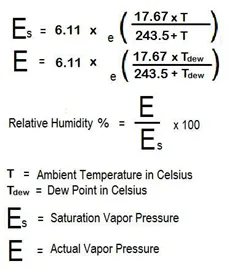

In [38]:
train_df['relative_humidity']= 100*((np.exp((17.67*train_df['dew_temperature'])/
                                            (243.5+train_df['dew_temperature'])))/(np.exp((17.67*train_df['air_temperature'])/
                                                                                          (243.5+train_df['air_temperature']))))


In [39]:
train_df.to_csv(r'C:\Users\imate\Documents\24.9.Notebooks_training\Final-pipeline\data\processed\fe_data_train.csv')